# RCによる外力ありのVDPの予測を行う。

まず、ライブラリをインポートする。

In [163]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge

from reservoirpy.observables import nrmse, rsquare

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

VDPモデルを数値シミュレーションする。

timestepは2510に設定する。

（内訳：
学習期間は1000ステップ。

テスト期間は1000ステップ。

その後500ステップ弱をGenerative Modelで予測する。
）


In [164]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

In [165]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 2510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 2510))

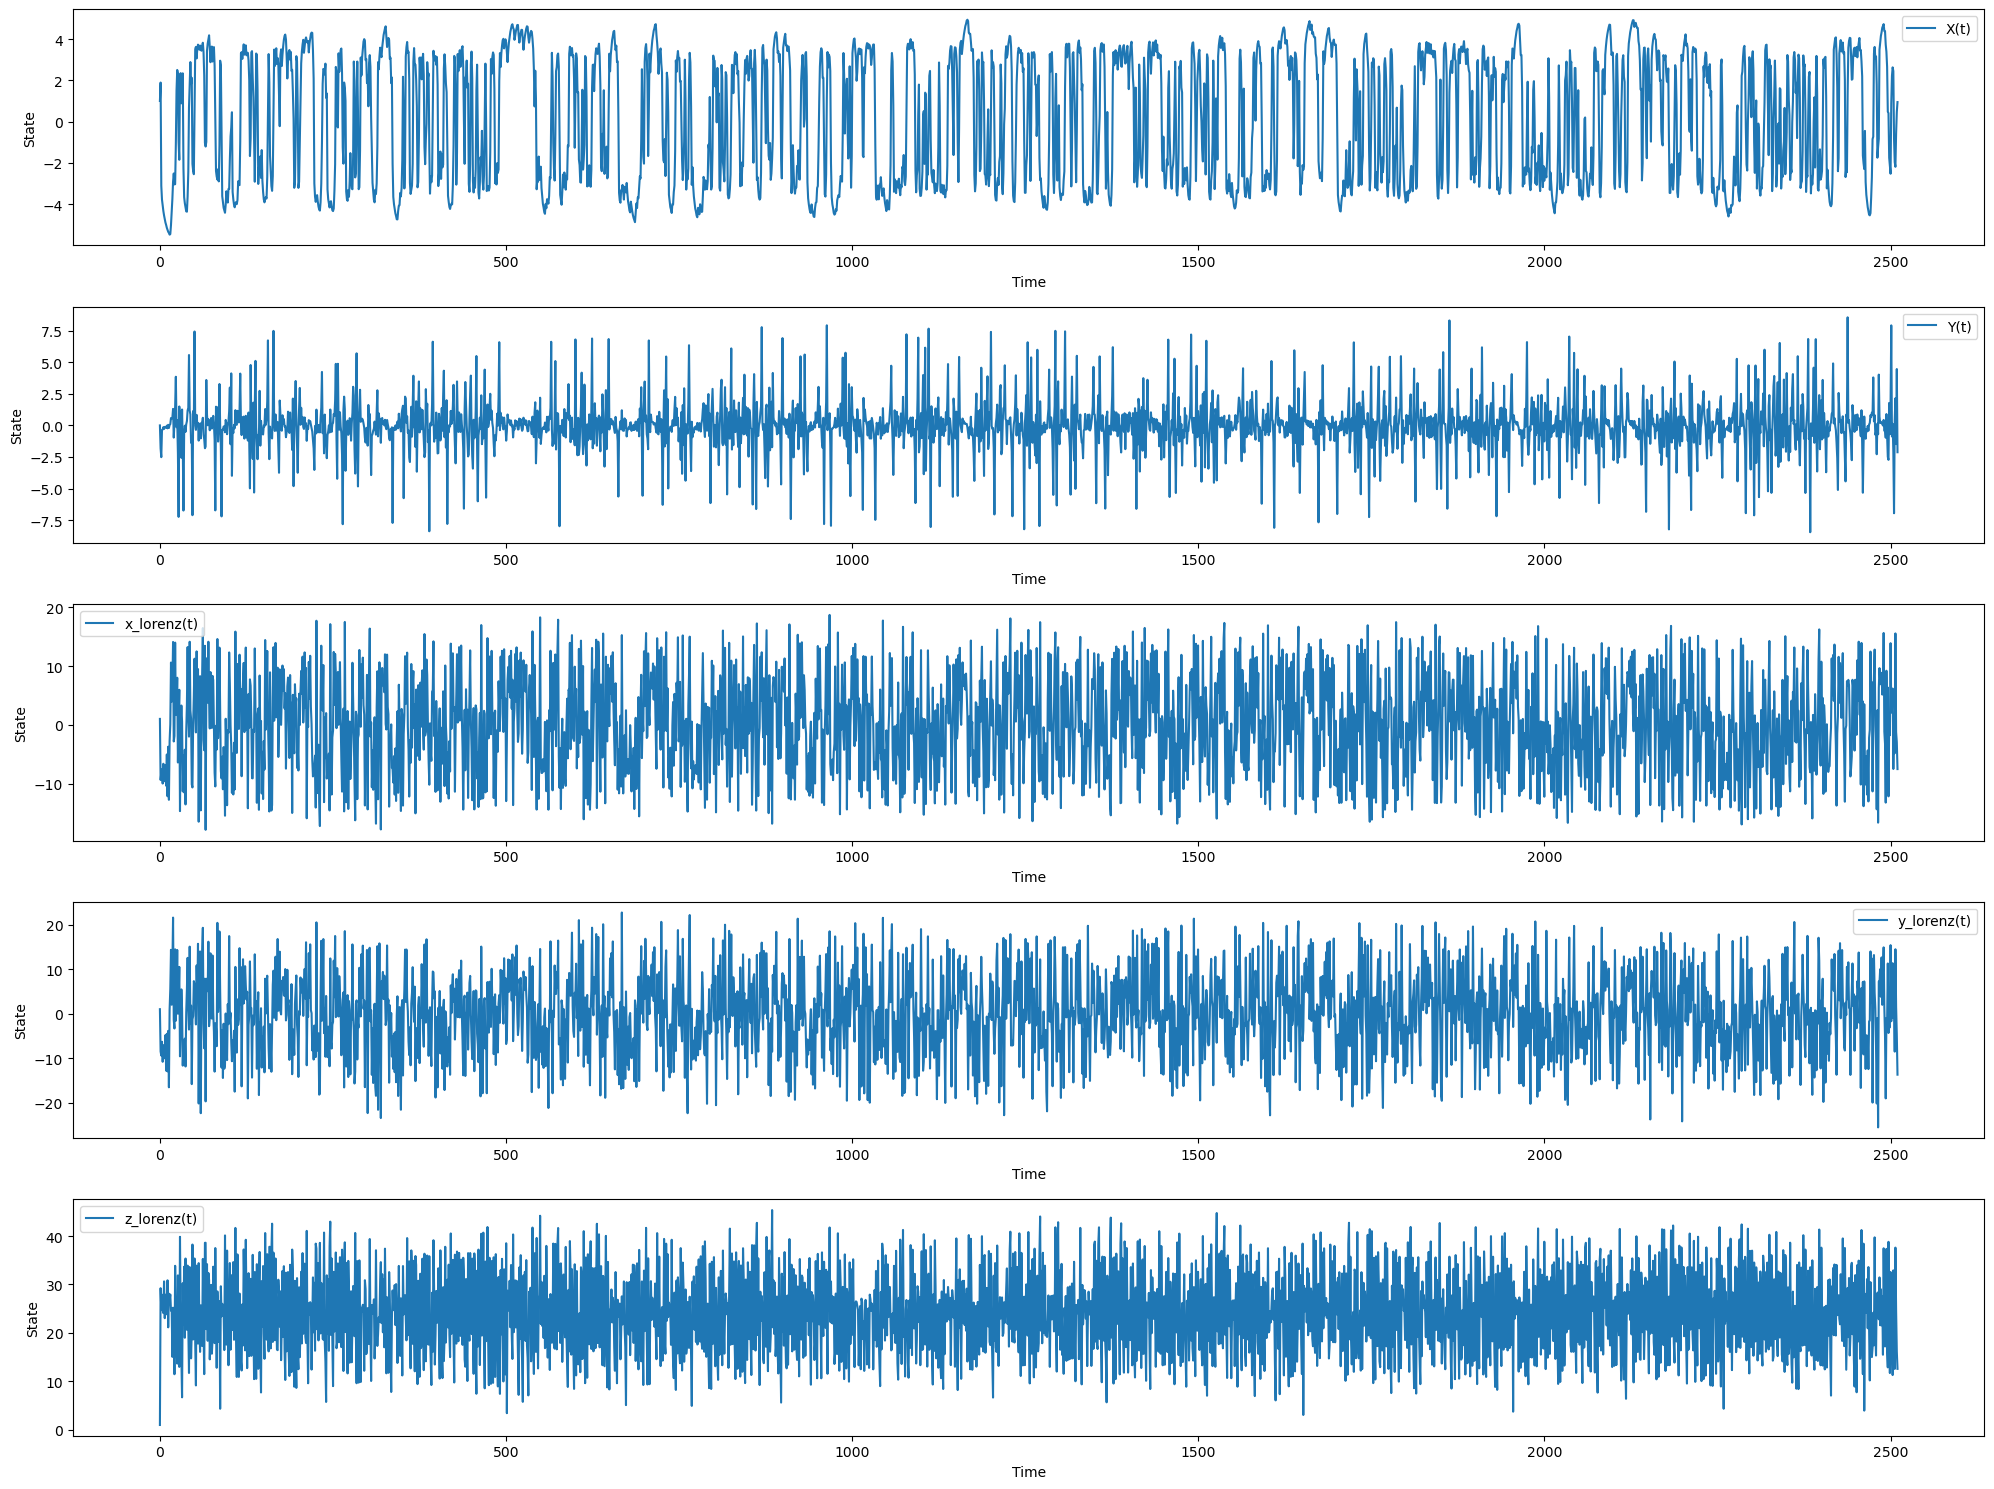

In [166]:
# Plot the results
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t, sol.y[2], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t, sol.y[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t, sol.y[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [167]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'x_lorenz': sol.y[2]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [168]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [169]:
X = data.values

In [170]:
X.shape

(2510, 2)

これで、2510にわたる、ローレンツモデルのx項を外力に持つVDPの配列を得ることができた。

#### 学習させるのは、どのパラメータ？

描画は後にする。

In [171]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [172]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],           # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

データを準備する。

学習期間は1000ステップ。
テスト期間は1000ステップ。

In [173]:
from reservoirpy.datasets import to_forecasting

train_len = 2000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:2000], y[:2000]
X_test, y_test = x[2000:], y[2000:]

dataset = ((X_train, y_train), (X_test, y_test))

In [174]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

 37%|███▋      | 74/200 [01:09<01:56,  1.09trial/s, best loss: 0.1512439080868935]

In [ ]:
best

({'N': 0,
  'iss': 0,
  'lr': 0.8066803683138792,
  'ridge': 0,
  'seed': 0,
  'sr': 0.02045819673305219},
 <hyperopt.base.Trials at 0x28cc5a910>)

In [88]:
hyperparameters = {
    'N': 0,
    'iss': 0,
    'lr': 0.8066803683138792,
    'ridge': 0,
    'seed': 0,
    'sr': 0.02045819673305219
}

In [89]:
hyperparameters['N'] = 500
hyperparameters['iss'] = 0.9
hyperparameters['ridge'] = 1e-7
hyperparameters['seed'] = 1234
hyperparameters

{'N': 500,
 'iss': 0.9,
 'lr': 0.8066803683138792,
 'ridge': 1e-07,
 'seed': 1234,
 'sr': 0.02045819673305219}

In [90]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [91]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.9
lr = 0.8066803683138792
ridge = 1e-7
seed = 1234
sr = 0.02045819673305219

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.08803655409836972
R^2: 0.7382322680625839


ここまで、通常の1期先予測の方法を見た。

さて、ここから、ESNに自分の予測に基づいて、100期先までを予測してもらう。

# Generative Modelを使う。

In [152]:
seed_timesteps = 100

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup

In [153]:
nb_generations = 30

X_gen = np.zeros((nb_generations, 2))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = model(y)
    X_gen[t, :] = y

In [154]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 15))
    
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [155]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps]
X_t_X.shape

(30, 5)

In [151]:
X_t_X

array([], shape=(0, 5), dtype=float64)

In [139]:
X_gen

array([[   86.57086244,   670.94381756,  3813.78665118,    27.75335934,
        -1969.52285214],
       [  -57.90656643,  1901.76223432, 11793.9147368 , -4224.58535431,
        -7752.51291606],
       [  -34.99734063,  2267.72073037, 13924.47000458, -4551.42041095,
        -8955.02479084],
       [  -21.49406059,  2361.83110175, 14434.24914731, -4527.84904744,
        -9193.5559673 ],
       [  -16.61578709,  2385.45510187, 14557.96322908, -4501.79130682,
        -9230.94688873],
       [  -15.17464128,  2391.24248759, 14587.87632358, -4491.73690075,
        -9234.84596635],
       [  -14.79423598,  2392.63248028, 14595.01997645, -4488.67425212,
        -9234.68590821],
       [  -14.70108324,  2392.96095102, 14596.6995075 , -4487.84086546,
        -9234.43512241],
       [  -14.67951954,  2393.03751438, 14597.08805949, -4487.62905934,
        -9234.33751363],
       [  -14.67475333,  2393.05514908, 14597.17657372, -4487.57769251,
        -9234.3081913 ],
       [  -14.67374253,  2393.

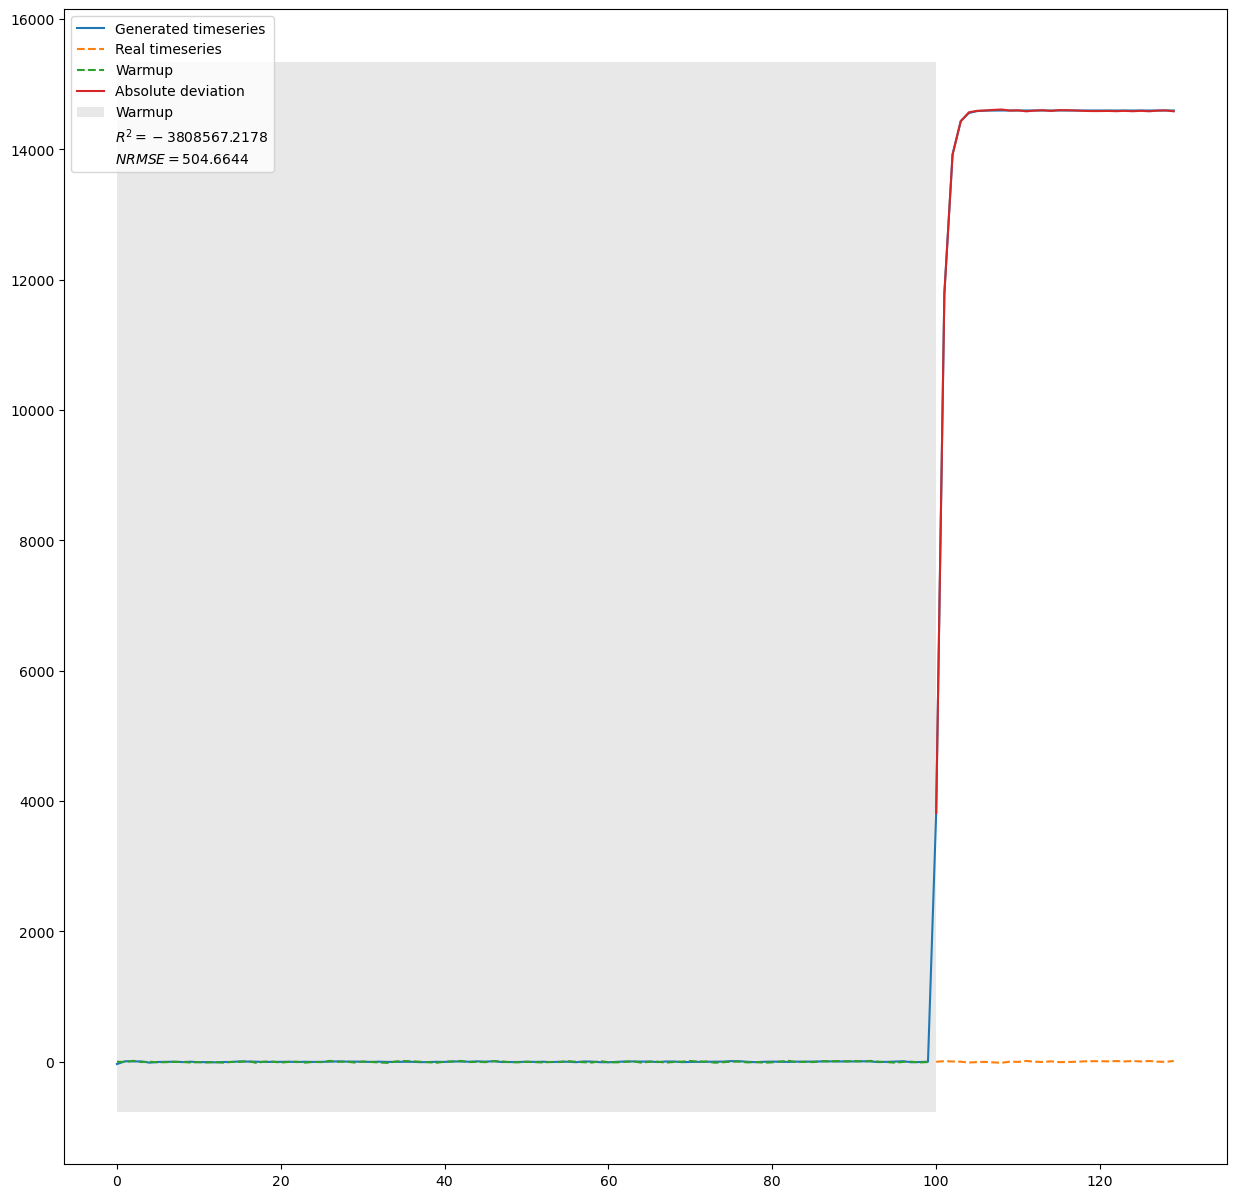

In [135]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, 1:2]

#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, 1:2], X_t_X, nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)